In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import LabelEncoder

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
# 결측치 채우기
train['Embarked'] = train['Embarked'].fillna("S")
train['Age'] = train['Age'].interpolate(method = 'linear')

test['Fare'] = test['Fare'].interpolate(mathod = "linear")
test['Age'] = test['Age'].interpolate(method = 'linear')

# Name 으로 호칭 추출하기
def get_title(name):   # 함수로 더욱 세분화된 나이분류
    title = ''
    if 'Mr' in name : title = 'Mr'
    elif 'Mrs' in name: title = 'Miss'
    elif 'Ms' in name : title = 'Miss'
    elif 'Miss' in name : title = 'Miss'
    elif 'Mlle' in name : title = 'Miss'
    elif 'Mme' in name : title = 'Miss'
    elif 'Master' in name : title = 'Master'
    else : title = 'Etc'
    return title
train['Title'] = train['Name'].apply(lambda x : get_title(x))
test['Title'] = test['Name'].apply(lambda x : get_title(x))

# SibSp(형제or배우자 수) 와 Parch(부모or자녀 수)를 이용해 가족규모 추출
train['FamilySize'] = train['SibSp'] + train['Parch']
test['FamilySize'] = test['SibSp'] + test['Parch']

train['FamilySize'] = train['FamilySize'].apply(lambda x : 0 if x == 0 else 1 )
test['FamilySize'] = test['FamilySize'].apply(lambda x : 0 if x == 0 else 1)

# 나이를 카테고리형으로 나눔
def get_age(age):   # 함수로 더욱 세분화된 나이분류
    cat = ''
    if age <= 5: cat = 'Baby'
    elif age <= 12: cat = 'Child'
    elif age <= 18: cat = 'Teenager'
    elif age <= 25: cat = 'Student'
    elif age <= 35: cat = 'Young Adult'
    elif age <= 60: cat = 'Adult'
    else : cat = 'Elderly'
    
    return cat

train['Age_cat'] = train['Age'].apply(lambda x : get_age(x))
test['Age_cat'] = test['Age'].apply(lambda x : get_age(x))

# 성별을 남자는 0 여자는 1 로 변경
train['Sex'] = train['Sex'].replace('male',0)
train['Sex'] = train['Sex'].replace('female',1)

test['Sex'] = test['Sex'].replace('male',0)
test['Sex'] = test['Sex'].replace('female',1)

# Embarked를 S는0 C는1 Q는2 로 변경
train['Embarked'] = train['Embarked'].replace('S',0)
train['Embarked'] = train['Embarked'].replace('C',1)
train['Embarked'] = train['Embarked'].replace('Q',2)

test['Embarked'] = test['Embarked'].replace('S',0)
test['Embarked'] = test['Embarked'].replace('C',1)
test['Embarked'] = test['Embarked'].replace('Q',2)

# Cabin(선실)의 보유여부에 따라 새로운 칼럼을 만들어주었다
train['Cabin'] = train["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
test['Cabin'] = test["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

# 필요없는 칼럼 제거
train.drop(['PassengerId'],axis=1,inplace = True)
train.drop(['Name'],axis=1,inplace = True)
train.drop(['Ticket'],axis=1,inplace = True)

test.drop(['PassengerId'],axis=1,inplace = True)
test.drop(['Name'],axis=1,inplace = True)
test.drop(['Ticket'],axis=1,inplace = True)

# 카테고리형 칼럼들은 모두 원핫 인코딩해주었다.
train = pd.get_dummies(train)
test = pd.get_dummies(test)

# Fare 칼럼 정규화
train['Fare'] = np.log1p(train['Fare'])
test['Fare'] = np.log1p(test['Fare'])

# Age 칼럼 정규화
train['Age'] = np.log1p(train['Age'])
test['Age'] = np.log1p(test['Age'])

In [5]:
train.dropna(axis=0, inplace=True)

In [6]:
X = train.drop('Survived', axis=1)
Y = train['Survived']

In [7]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Pclass               891 non-null    int64  
 1   Sex                  891 non-null    int64  
 2   Age                  891 non-null    float64
 3   SibSp                891 non-null    int64  
 4   Parch                891 non-null    int64  
 5   Fare                 891 non-null    float64
 6   Cabin                891 non-null    int64  
 7   Embarked             891 non-null    int64  
 8   FamilySize           891 non-null    int64  
 9   Title_Etc            891 non-null    uint8  
 10  Title_Master         891 non-null    uint8  
 11  Title_Miss           891 non-null    uint8  
 12  Title_Mr             891 non-null    uint8  
 13  Age_cat_Adult        891 non-null    uint8  
 14  Age_cat_Baby         891 non-null    uint8  
 15  Age_cat_Child        891 non-null    uin

In [27]:
# 기본
model = Sequential()

model.add(Dense(30, input_dim=20, activation = 'relu'))
model.add(Dense(10, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = 'accuracy')

model.fit(X, Y, epochs = 500, batch_size = 50)

# 결과출력
model.evaluate(X,Y)

Epoch 1/500
18/18 [==============================] - 1s 1ms/step - loss: 0.8841 - accuracy: 0.3906
Epoch 2/500
18/18 [==============================] - 0s 2ms/step - loss: 0.7046 - accuracy: 0.5331
Epoch 3/500
18/18 [==============================] - 0s 2ms/step - loss: 0.6334 - accuracy: 0.7048
Epoch 4/500
18/18 [==============================] - 0s 2ms/step - loss: 0.5989 - accuracy: 0.7183
Epoch 5/500
18/18 [==============================] - 0s 2ms/step - loss: 0.5535 - accuracy: 0.7430
Epoch 6/500
18/18 [==============================] - 0s 2ms/step - loss: 0.5133 - accuracy: 0.7688
Epoch 7/500
18/18 [==============================] - 0s 2ms/step - loss: 0.4862 - accuracy: 0.7722
Epoch 8/500
18/18 [==============================] - 0s 2ms/step - loss: 0.4699 - accuracy: 0.7800
Epoch 9/500
18/18 [==============================] - 0s 2ms/step - loss: 0.4578 - accuracy: 0.7845
Epoch 10/500
18/18 [==============================] - 0s 2ms/step - loss: 0.4506 - accuracy: 0.7980
Epoch 11/

18/18 [==============================] - 0s 3ms/step - loss: 0.3451 - accuracy: 0.8519
Epoch 84/500
18/18 [==============================] - 0s 2ms/step - loss: 0.3436 - accuracy: 0.8586
Epoch 85/500
18/18 [==============================] - 0s 2ms/step - loss: 0.3430 - accuracy: 0.8552
Epoch 86/500
18/18 [==============================] - 0s 2ms/step - loss: 0.3425 - accuracy: 0.8586
Epoch 87/500
18/18 [==============================] - 0s 2ms/step - loss: 0.3444 - accuracy: 0.8541
Epoch 88/500
18/18 [==============================] - 0s 2ms/step - loss: 0.3406 - accuracy: 0.8541
Epoch 89/500
18/18 [==============================] - 0s 2ms/step - loss: 0.3410 - accuracy: 0.8530
Epoch 90/500
18/18 [==============================] - 0s 2ms/step - loss: 0.3410 - accuracy: 0.8541
Epoch 91/500
18/18 [==============================] - 0s 2ms/step - loss: 0.3399 - accuracy: 0.8563
Epoch 92/500
18/18 [==============================] - 0s 2ms/step - loss: 0.3389 - accuracy: 0.8586
Epoch 93/500


18/18 [==============================] - 0s 2ms/step - loss: 0.3091 - accuracy: 0.8642
Epoch 165/500
18/18 [==============================] - 0s 2ms/step - loss: 0.3096 - accuracy: 0.8642
Epoch 166/500
18/18 [==============================] - 0s 2ms/step - loss: 0.3173 - accuracy: 0.8687
Epoch 167/500
18/18 [==============================] - 0s 2ms/step - loss: 0.3147 - accuracy: 0.8676
Epoch 168/500
18/18 [==============================] - 0s 1ms/step - loss: 0.3095 - accuracy: 0.8687
Epoch 169/500
18/18 [==============================] - 0s 1ms/step - loss: 0.3077 - accuracy: 0.8709
Epoch 170/500
18/18 [==============================] - 0s 2ms/step - loss: 0.3087 - accuracy: 0.8687
Epoch 171/500
18/18 [==============================] - 0s 1ms/step - loss: 0.3095 - accuracy: 0.8687
Epoch 172/500
18/18 [==============================] - 0s 1ms/step - loss: 0.3070 - accuracy: 0.8698
Epoch 173/500
18/18 [==============================] - 0s 1ms/step - loss: 0.3075 - accuracy: 0.8721
Epoc

18/18 [==============================] - 0s 2ms/step - loss: 0.2915 - accuracy: 0.8788
Epoch 246/500
18/18 [==============================] - 0s 2ms/step - loss: 0.2899 - accuracy: 0.8777
Epoch 247/500
18/18 [==============================] - 0s 2ms/step - loss: 0.2918 - accuracy: 0.8810
Epoch 248/500
18/18 [==============================] - 0s 2ms/step - loss: 0.2909 - accuracy: 0.8810
Epoch 249/500
18/18 [==============================] - 0s 2ms/step - loss: 0.2892 - accuracy: 0.8799
Epoch 250/500
18/18 [==============================] - 0s 2ms/step - loss: 0.2951 - accuracy: 0.8732
Epoch 251/500
18/18 [==============================] - 0s 2ms/step - loss: 0.2925 - accuracy: 0.8732
Epoch 252/500
18/18 [==============================] - 0s 2ms/step - loss: 0.2908 - accuracy: 0.8788
Epoch 253/500
18/18 [==============================] - 0s 2ms/step - loss: 0.2875 - accuracy: 0.8765
Epoch 254/500
18/18 [==============================] - 0s 2ms/step - loss: 0.2905 - accuracy: 0.8721
Epoc

18/18 [==============================] - 0s 2ms/step - loss: 0.2797 - accuracy: 0.8822
Epoch 327/500
18/18 [==============================] - 0s 2ms/step - loss: 0.2819 - accuracy: 0.8721
Epoch 328/500
18/18 [==============================] - 0s 2ms/step - loss: 0.2791 - accuracy: 0.8833
Epoch 329/500
18/18 [==============================] - 0s 2ms/step - loss: 0.2791 - accuracy: 0.8822
Epoch 330/500
18/18 [==============================] - 0s 2ms/step - loss: 0.2780 - accuracy: 0.8866
Epoch 331/500
18/18 [==============================] - 0s 2ms/step - loss: 0.2794 - accuracy: 0.8844
Epoch 332/500
18/18 [==============================] - 0s 2ms/step - loss: 0.2789 - accuracy: 0.8844
Epoch 333/500
18/18 [==============================] - 0s 2ms/step - loss: 0.2801 - accuracy: 0.8799
Epoch 334/500
18/18 [==============================] - 0s 2ms/step - loss: 0.2776 - accuracy: 0.8833
Epoch 335/500
18/18 [==============================] - 0s 2ms/step - loss: 0.2770 - accuracy: 0.8799
Epoc

18/18 [==============================] - 0s 2ms/step - loss: 0.2706 - accuracy: 0.8810
Epoch 408/500
18/18 [==============================] - 0s 2ms/step - loss: 0.2714 - accuracy: 0.8956
Epoch 409/500
18/18 [==============================] - 0s 1ms/step - loss: 0.2688 - accuracy: 0.8844
Epoch 410/500
18/18 [==============================] - 0s 1ms/step - loss: 0.2684 - accuracy: 0.8934
Epoch 411/500
18/18 [==============================] - 0s 1ms/step - loss: 0.2698 - accuracy: 0.8822
Epoch 412/500
18/18 [==============================] - 0s 1ms/step - loss: 0.2721 - accuracy: 0.8900
Epoch 413/500
18/18 [==============================] - 0s 1ms/step - loss: 0.2674 - accuracy: 0.8889
Epoch 414/500
18/18 [==============================] - 0s 2ms/step - loss: 0.2689 - accuracy: 0.8878
Epoch 415/500
18/18 [==============================] - 0s 1ms/step - loss: 0.2671 - accuracy: 0.8855
Epoch 416/500
18/18 [==============================] - 0s 1ms/step - loss: 0.2685 - accuracy: 0.8911
Epoc

18/18 [==============================] - 0s 2ms/step - loss: 0.2615 - accuracy: 0.8923
Epoch 489/500
18/18 [==============================] - 0s 2ms/step - loss: 0.2594 - accuracy: 0.8889
Epoch 490/500
18/18 [==============================] - 0s 2ms/step - loss: 0.2606 - accuracy: 0.8911
Epoch 491/500
18/18 [==============================] - 0s 2ms/step - loss: 0.2618 - accuracy: 0.8990
Epoch 492/500
18/18 [==============================] - 0s 2ms/step - loss: 0.2641 - accuracy: 0.8855
Epoch 493/500
18/18 [==============================] - 0s 2ms/step - loss: 0.2583 - accuracy: 0.8934
Epoch 494/500
18/18 [==============================] - 0s 2ms/step - loss: 0.2586 - accuracy: 0.8967
Epoch 495/500
18/18 [==============================] - 0s 2ms/step - loss: 0.2625 - accuracy: 0.8945
Epoch 496/500
18/18 [==============================] - 0s 2ms/step - loss: 0.2616 - accuracy: 0.8878
Epoch 497/500
18/18 [==============================] - 0s 2ms/step - loss: 0.2606 - accuracy: 0.8866
Epoc

[0.2539444863796234, 0.8989899158477783]

In [10]:
# K-fold 이용하기
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits = 5, shuffle =True)
accuracy = []

# K-fold 방식 (iloc을 쓰자)
for train_idx,test_idx in skf.split(X,Y):
    x_train, x_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = Y.iloc[train_idx], Y.iloc[test_idx]
    model = Sequential()
    model.add(Dense(16, input_dim = 20, activation = 'relu'))
    model.add(Dense(10, activation = 'relu'))
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = 'accuracy')
    model.fit(x_train, y_train, epochs = 500, batch_size = 100)
    
    accuracy.append(model.evaluate(x_test,y_test)[1])

print(accuracy)

Epoch 1/500
8/8 [==============================] - 1s 2ms/step - loss: 0.6688 - accuracy: 0.5941
Epoch 2/500
8/8 [==============================] - 0s 2ms/step - loss: 0.6586 - accuracy: 0.6067
Epoch 3/500
8/8 [==============================] - 0s 2ms/step - loss: 0.6506 - accuracy: 0.6138
Epoch 4/500
8/8 [==============================] - 0s 2ms/step - loss: 0.6435 - accuracy: 0.6194
Epoch 5/500
8/8 [==============================] - 0s 2ms/step - loss: 0.6364 - accuracy: 0.6194
Epoch 6/500
8/8 [==============================] - 0s 2ms/step - loss: 0.6299 - accuracy: 0.6376
Epoch 7/500
8/8 [==============================] - 0s 2ms/step - loss: 0.6227 - accuracy: 0.6475
Epoch 8/500
8/8 [==============================] - 0s 2ms/step - loss: 0.6146 - accuracy: 0.6404
Epoch 9/500
8/8 [==============================] - 0s 2ms/step - loss: 0.6074 - accuracy: 0.6475
Epoch 10/500
8/8 [==============================] - 0s 2ms/step - loss: 0.6004 - accuracy: 0.6615
Epoch 11/500
8/8 [===========

8/8 [==============================] - 0s 2ms/step - loss: 0.3989 - accuracy: 0.8385
Epoch 85/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3985 - accuracy: 0.8385
Epoch 86/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3979 - accuracy: 0.8399
Epoch 87/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3974 - accuracy: 0.8413
Epoch 88/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3974 - accuracy: 0.8385
Epoch 89/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3959 - accuracy: 0.8413
Epoch 90/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3956 - accuracy: 0.8427
Epoch 91/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3964 - accuracy: 0.8399
Epoch 92/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3947 - accuracy: 0.8413
Epoch 93/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3944 - accuracy: 0.8371
Epoch 94/500
8/8 [===============

8/8 [==============================] - 0s 2ms/step - loss: 0.3685 - accuracy: 0.8511
Epoch 168/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3690 - accuracy: 0.8483
Epoch 169/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3678 - accuracy: 0.8511
Epoch 170/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3682 - accuracy: 0.8497
Epoch 171/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3686 - accuracy: 0.8525
Epoch 172/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3689 - accuracy: 0.8525
Epoch 173/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3677 - accuracy: 0.8553
Epoch 174/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3677 - accuracy: 0.8497
Epoch 175/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3669 - accuracy: 0.8483
Epoch 176/500
8/8 [==============================] - 0s 1ms/step - loss: 0.3687 - accuracy: 0.8441
Epoch 177/500
8/8 [=====

8/8 [==============================] - 0s 2ms/step - loss: 0.3543 - accuracy: 0.8483
Epoch 250/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3541 - accuracy: 0.8455
Epoch 251/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3546 - accuracy: 0.8455
Epoch 252/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3540 - accuracy: 0.8455
Epoch 253/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3537 - accuracy: 0.8497
Epoch 254/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3538 - accuracy: 0.8553
Epoch 255/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3535 - accuracy: 0.8497
Epoch 256/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3531 - accuracy: 0.8497
Epoch 257/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3538 - accuracy: 0.8525
Epoch 258/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3533 - accuracy: 0.8596
Epoch 259/500
8/8 [=====

8/8 [==============================] - 0s 2ms/step - loss: 0.3443 - accuracy: 0.8497
Epoch 332/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3425 - accuracy: 0.8525
Epoch 333/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3418 - accuracy: 0.8525
Epoch 334/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3417 - accuracy: 0.8539
Epoch 335/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3423 - accuracy: 0.8553
Epoch 336/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3415 - accuracy: 0.8497
Epoch 337/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3415 - accuracy: 0.8511
Epoch 338/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3405 - accuracy: 0.8539
Epoch 339/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3402 - accuracy: 0.8567
Epoch 340/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3400 - accuracy: 0.8567
Epoch 341/500
8/8 [=====

8/8 [==============================] - 0s 3ms/step - loss: 0.3309 - accuracy: 0.8596
Epoch 414/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3308 - accuracy: 0.8581
Epoch 415/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3307 - accuracy: 0.8553
Epoch 416/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3309 - accuracy: 0.8596
Epoch 417/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3316 - accuracy: 0.8624
Epoch 418/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3309 - accuracy: 0.8638
Epoch 419/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3309 - accuracy: 0.8610
Epoch 420/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3322 - accuracy: 0.8525
Epoch 421/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3324 - accuracy: 0.8511
Epoch 422/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3293 - accuracy: 0.8596
Epoch 423/500
8/8 [=====

8/8 [==============================] - 0s 2ms/step - loss: 0.3232 - accuracy: 0.8553
Epoch 496/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3225 - accuracy: 0.8596
Epoch 497/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3222 - accuracy: 0.8624
Epoch 498/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3225 - accuracy: 0.8581
Epoch 499/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3228 - accuracy: 0.8581
Epoch 500/500
6/6 [==============================] - 0s 2ms/step - loss: 0.4310 - accuracy: 0.7933
Epoch 1/500
8/8 [==============================] - 1s 2ms/step - loss: 1.1633 - accuracy: 0.3843
Epoch 2/500
8/8 [==============================] - 0s 2ms/step - loss: 1.0207 - accuracy: 0.3843
Epoch 3/500
8/8 [==============================] - 0s 2ms/step - loss: 0.9138 - accuracy: 0.3843
Epoch 4/500
8/8 [==============================] - 0s 2ms/step - loss: 0.8420 - accuracy: 0.3843
Epoch 5/500
8/8 [===============

8/8 [==============================] - 0s 2ms/step - loss: 0.3755 - accuracy: 0.8471
Epoch 78/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3723 - accuracy: 0.8513
Epoch 79/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3728 - accuracy: 0.8429
Epoch 80/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3716 - accuracy: 0.8457
Epoch 81/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3704 - accuracy: 0.8457
Epoch 82/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3717 - accuracy: 0.8457
Epoch 83/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3714 - accuracy: 0.8429
Epoch 84/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3689 - accuracy: 0.8485
Epoch 85/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3693 - accuracy: 0.8471
Epoch 86/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3686 - accuracy: 0.8513
Epoch 87/500
8/8 [===============

8/8 [==============================] - 0s 2ms/step - loss: 0.3482 - accuracy: 0.8555
Epoch 161/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3469 - accuracy: 0.8569
Epoch 162/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3476 - accuracy: 0.8555
Epoch 163/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3468 - accuracy: 0.8513
Epoch 164/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3452 - accuracy: 0.8583
Epoch 165/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3467 - accuracy: 0.8541
Epoch 166/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3449 - accuracy: 0.8569
Epoch 167/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3479 - accuracy: 0.8527
Epoch 168/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3462 - accuracy: 0.8569
Epoch 169/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3447 - accuracy: 0.8583
Epoch 170/500
8/8 [=====

8/8 [==============================] - 0s 2ms/step - loss: 0.3324 - accuracy: 0.8612
Epoch 243/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3406 - accuracy: 0.8541
Epoch 244/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3399 - accuracy: 0.8569
Epoch 245/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3366 - accuracy: 0.8583
Epoch 246/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3355 - accuracy: 0.8499
Epoch 247/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3330 - accuracy: 0.8555
Epoch 248/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3343 - accuracy: 0.8597
Epoch 249/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3348 - accuracy: 0.8612
Epoch 250/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3319 - accuracy: 0.8612
Epoch 251/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3318 - accuracy: 0.8626
Epoch 252/500
8/8 [=====

8/8 [==============================] - 0s 3ms/step - loss: 0.3223 - accuracy: 0.8640
Epoch 325/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3231 - accuracy: 0.8724
Epoch 326/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3219 - accuracy: 0.8640
Epoch 327/500
8/8 [==============================] - 0s 3ms/step - loss: 0.3194 - accuracy: 0.8682
Epoch 328/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3196 - accuracy: 0.8668
Epoch 329/500
8/8 [==============================] - 0s 3ms/step - loss: 0.3199 - accuracy: 0.8668
Epoch 330/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3224 - accuracy: 0.8626
Epoch 331/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3211 - accuracy: 0.8640
Epoch 332/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3210 - accuracy: 0.8682
Epoch 333/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3199 - accuracy: 0.8668
Epoch 334/500
8/8 [=====

8/8 [==============================] - 0s 2ms/step - loss: 0.3104 - accuracy: 0.8710
Epoch 407/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3106 - accuracy: 0.8752
Epoch 408/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3105 - accuracy: 0.8724
Epoch 409/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3112 - accuracy: 0.8724
Epoch 410/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3107 - accuracy: 0.8682
Epoch 411/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3113 - accuracy: 0.8682
Epoch 412/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3110 - accuracy: 0.8752
Epoch 413/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3101 - accuracy: 0.8724
Epoch 414/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3106 - accuracy: 0.8710
Epoch 415/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3101 - accuracy: 0.8738
Epoch 416/500
8/8 [=====

8/8 [==============================] - 0s 2ms/step - loss: 0.3036 - accuracy: 0.8766
Epoch 489/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3040 - accuracy: 0.8766
Epoch 490/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3027 - accuracy: 0.8808
Epoch 491/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3059 - accuracy: 0.8710
Epoch 492/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3048 - accuracy: 0.8780
Epoch 493/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3087 - accuracy: 0.8752
Epoch 494/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3008 - accuracy: 0.8822
Epoch 495/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3049 - accuracy: 0.8766
Epoch 496/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3033 - accuracy: 0.8780
Epoch 497/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3020 - accuracy: 0.8808
Epoch 498/500
8/8 [=====

8/8 [==============================] - 0s 2ms/step - loss: 0.4084 - accuracy: 0.8177
Epoch 71/500
8/8 [==============================] - 0s 2ms/step - loss: 0.4062 - accuracy: 0.8205
Epoch 72/500
8/8 [==============================] - 0s 2ms/step - loss: 0.4071 - accuracy: 0.8191
Epoch 73/500
8/8 [==============================] - 0s 2ms/step - loss: 0.4071 - accuracy: 0.8191
Epoch 74/500
8/8 [==============================] - 0s 2ms/step - loss: 0.4042 - accuracy: 0.8191
Epoch 75/500
8/8 [==============================] - 0s 2ms/step - loss: 0.4049 - accuracy: 0.8289
Epoch 76/500
8/8 [==============================] - 0s 2ms/step - loss: 0.4065 - accuracy: 0.8219
Epoch 77/500
8/8 [==============================] - 0s 4ms/step - loss: 0.4032 - accuracy: 0.8205
Epoch 78/500
8/8 [==============================] - 0s 2ms/step - loss: 0.4034 - accuracy: 0.8191
Epoch 79/500
8/8 [==============================] - 0s 2ms/step - loss: 0.4032 - accuracy: 0.8261
Epoch 80/500
8/8 [===============

8/8 [==============================] - 0s 2ms/step - loss: 0.3827 - accuracy: 0.8331
Epoch 154/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3810 - accuracy: 0.8331
Epoch 155/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3821 - accuracy: 0.8275
Epoch 156/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3809 - accuracy: 0.8275
Epoch 157/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3813 - accuracy: 0.8373
Epoch 158/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3808 - accuracy: 0.8345
Epoch 159/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3807 - accuracy: 0.8289
Epoch 160/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3806 - accuracy: 0.8359
Epoch 161/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3806 - accuracy: 0.8345
Epoch 162/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3820 - accuracy: 0.8289
Epoch 163/500
8/8 [=====

8/8 [==============================] - 0s 2ms/step - loss: 0.3733 - accuracy: 0.8401
Epoch 236/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3720 - accuracy: 0.8373
Epoch 237/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3720 - accuracy: 0.8303
Epoch 238/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3697 - accuracy: 0.8401
Epoch 239/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3711 - accuracy: 0.8415
Epoch 240/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3701 - accuracy: 0.8429
Epoch 241/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3703 - accuracy: 0.8359
Epoch 242/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3706 - accuracy: 0.8373
Epoch 243/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3704 - accuracy: 0.8373
Epoch 244/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3691 - accuracy: 0.8359
Epoch 245/500
8/8 [=====

8/8 [==============================] - 0s 2ms/step - loss: 0.3639 - accuracy: 0.8415
Epoch 318/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3622 - accuracy: 0.8415
Epoch 319/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3624 - accuracy: 0.8401
Epoch 320/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3621 - accuracy: 0.8401
Epoch 321/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3620 - accuracy: 0.8387
Epoch 322/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3612 - accuracy: 0.8429
Epoch 323/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3628 - accuracy: 0.8443
Epoch 324/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3634 - accuracy: 0.8443
Epoch 325/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3611 - accuracy: 0.8443
Epoch 326/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3623 - accuracy: 0.8387
Epoch 327/500
8/8 [=====

8/8 [==============================] - 0s 2ms/step - loss: 0.3550 - accuracy: 0.8401
Epoch 400/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3557 - accuracy: 0.8443
Epoch 401/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3562 - accuracy: 0.8443
Epoch 402/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3558 - accuracy: 0.8373
Epoch 403/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3553 - accuracy: 0.8373
Epoch 404/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3551 - accuracy: 0.8359
Epoch 405/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3541 - accuracy: 0.8345
Epoch 406/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3554 - accuracy: 0.8345
Epoch 407/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3551 - accuracy: 0.8429
Epoch 408/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3538 - accuracy: 0.8415
Epoch 409/500
8/8 [=====

8/8 [==============================] - 0s 2ms/step - loss: 0.3460 - accuracy: 0.8415
Epoch 482/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3469 - accuracy: 0.8387
Epoch 483/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3471 - accuracy: 0.8415
Epoch 484/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3467 - accuracy: 0.8499
Epoch 485/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3444 - accuracy: 0.8457
Epoch 486/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3446 - accuracy: 0.8415
Epoch 487/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3525 - accuracy: 0.8583
Epoch 488/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3486 - accuracy: 0.8485
Epoch 489/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3447 - accuracy: 0.8401
Epoch 490/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3451 - accuracy: 0.8387
Epoch 491/500
8/8 [=====

8/8 [==============================] - 0s 2ms/step - loss: 0.4115 - accuracy: 0.8177
Epoch 64/500
8/8 [==============================] - 0s 2ms/step - loss: 0.4113 - accuracy: 0.8205
Epoch 65/500
8/8 [==============================] - 0s 2ms/step - loss: 0.4094 - accuracy: 0.8163
Epoch 66/500
8/8 [==============================] - 0s 2ms/step - loss: 0.4091 - accuracy: 0.8163
Epoch 67/500
8/8 [==============================] - 0s 2ms/step - loss: 0.4077 - accuracy: 0.8177
Epoch 68/500
8/8 [==============================] - 0s 2ms/step - loss: 0.4078 - accuracy: 0.8149
Epoch 69/500
8/8 [==============================] - 0s 2ms/step - loss: 0.4070 - accuracy: 0.8135
Epoch 70/500
8/8 [==============================] - 0s 2ms/step - loss: 0.4071 - accuracy: 0.8149
Epoch 71/500
8/8 [==============================] - 0s 2ms/step - loss: 0.4056 - accuracy: 0.8205
Epoch 72/500
8/8 [==============================] - 0s 2ms/step - loss: 0.4056 - accuracy: 0.8233
Epoch 73/500
8/8 [===============

8/8 [==============================] - 0s 2ms/step - loss: 0.3768 - accuracy: 0.8387
Epoch 147/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3756 - accuracy: 0.8457
Epoch 148/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3750 - accuracy: 0.8499
Epoch 149/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3762 - accuracy: 0.8317
Epoch 150/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3800 - accuracy: 0.8303
Epoch 151/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3754 - accuracy: 0.8289
Epoch 152/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3735 - accuracy: 0.8429
Epoch 153/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3742 - accuracy: 0.8387
Epoch 154/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3716 - accuracy: 0.8499
Epoch 155/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3736 - accuracy: 0.8415
Epoch 156/500
8/8 [=====

8/8 [==============================] - 0s 2ms/step - loss: 0.3527 - accuracy: 0.8527
Epoch 229/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3528 - accuracy: 0.8485
Epoch 230/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3516 - accuracy: 0.8597
Epoch 231/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3509 - accuracy: 0.8612
Epoch 232/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3507 - accuracy: 0.8569
Epoch 233/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3588 - accuracy: 0.8359
Epoch 234/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3512 - accuracy: 0.8485
Epoch 235/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3525 - accuracy: 0.8569
Epoch 236/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3544 - accuracy: 0.8555
Epoch 237/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3547 - accuracy: 0.8527
Epoch 238/500
8/8 [=====

8/8 [==============================] - 0s 2ms/step - loss: 0.3375 - accuracy: 0.8640
Epoch 311/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3417 - accuracy: 0.8513
Epoch 312/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3412 - accuracy: 0.8527
Epoch 313/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3388 - accuracy: 0.8654
Epoch 314/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3376 - accuracy: 0.8597
Epoch 315/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3369 - accuracy: 0.8583
Epoch 316/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3372 - accuracy: 0.8569
Epoch 317/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3364 - accuracy: 0.8612
Epoch 318/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3367 - accuracy: 0.8569
Epoch 319/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3398 - accuracy: 0.8569
Epoch 320/500
8/8 [=====

8/8 [==============================] - 0s 2ms/step - loss: 0.3281 - accuracy: 0.8597
Epoch 393/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3260 - accuracy: 0.8640
Epoch 394/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3265 - accuracy: 0.8696
Epoch 395/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3277 - accuracy: 0.8640
Epoch 396/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3286 - accuracy: 0.8583
Epoch 397/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3252 - accuracy: 0.8696
Epoch 398/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3356 - accuracy: 0.8583
Epoch 399/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3308 - accuracy: 0.8626
Epoch 400/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3268 - accuracy: 0.8626
Epoch 401/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3260 - accuracy: 0.8640
Epoch 402/500
8/8 [=====

8/8 [==============================] - 0s 2ms/step - loss: 0.3199 - accuracy: 0.8724
Epoch 475/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3181 - accuracy: 0.8710
Epoch 476/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3181 - accuracy: 0.8682
Epoch 477/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3200 - accuracy: 0.8682
Epoch 478/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3227 - accuracy: 0.8668
Epoch 479/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3179 - accuracy: 0.8640
Epoch 480/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3257 - accuracy: 0.8597
Epoch 481/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3211 - accuracy: 0.8654
Epoch 482/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3182 - accuracy: 0.8682
Epoch 483/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3169 - accuracy: 0.8640
Epoch 484/500
8/8 [=====

8/8 [==============================] - 0s 2ms/step - loss: 0.3884 - accuracy: 0.8135
Epoch 57/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3892 - accuracy: 0.8205
Epoch 58/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3880 - accuracy: 0.8289
Epoch 59/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3887 - accuracy: 0.8247
Epoch 60/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3864 - accuracy: 0.8275
Epoch 61/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3853 - accuracy: 0.8317
Epoch 62/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3848 - accuracy: 0.8303
Epoch 63/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3833 - accuracy: 0.8303
Epoch 64/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3833 - accuracy: 0.8303
Epoch 65/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3818 - accuracy: 0.8331
Epoch 66/500
8/8 [===============

8/8 [==============================] - 0s 2ms/step - loss: 0.3444 - accuracy: 0.8541
Epoch 140/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3439 - accuracy: 0.8569
Epoch 141/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3445 - accuracy: 0.8555
Epoch 142/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3427 - accuracy: 0.8555
Epoch 143/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3437 - accuracy: 0.8583
Epoch 144/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3427 - accuracy: 0.8583
Epoch 145/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3421 - accuracy: 0.8555
Epoch 146/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3415 - accuracy: 0.8597
Epoch 147/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3418 - accuracy: 0.8597
Epoch 148/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3408 - accuracy: 0.8612
Epoch 149/500
8/8 [=====

8/8 [==============================] - 0s 2ms/step - loss: 0.3272 - accuracy: 0.8583
Epoch 222/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3248 - accuracy: 0.8583
Epoch 223/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3261 - accuracy: 0.8583
Epoch 224/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3250 - accuracy: 0.8626
Epoch 225/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3249 - accuracy: 0.8612
Epoch 226/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3251 - accuracy: 0.8612
Epoch 227/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3235 - accuracy: 0.8668
Epoch 228/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3266 - accuracy: 0.8738
Epoch 229/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3252 - accuracy: 0.8696
Epoch 230/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3230 - accuracy: 0.8654
Epoch 231/500
8/8 [=====

8/8 [==============================] - 0s 2ms/step - loss: 0.3124 - accuracy: 0.8640
Epoch 304/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3124 - accuracy: 0.8668
Epoch 305/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3131 - accuracy: 0.8612
Epoch 306/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3122 - accuracy: 0.8597
Epoch 307/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3127 - accuracy: 0.8612
Epoch 308/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3119 - accuracy: 0.8654
Epoch 309/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3119 - accuracy: 0.8696
Epoch 310/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3121 - accuracy: 0.8626
Epoch 311/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3121 - accuracy: 0.8640
Epoch 312/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3120 - accuracy: 0.8640
Epoch 313/500
8/8 [=====

8/8 [==============================] - 0s 2ms/step - loss: 0.3058 - accuracy: 0.8626
Epoch 386/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3041 - accuracy: 0.8640
Epoch 387/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3042 - accuracy: 0.8696
Epoch 388/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3044 - accuracy: 0.8612
Epoch 389/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3040 - accuracy: 0.8612
Epoch 390/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3036 - accuracy: 0.8668
Epoch 391/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3027 - accuracy: 0.8766
Epoch 392/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3018 - accuracy: 0.8682
Epoch 393/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3042 - accuracy: 0.8696
Epoch 394/500
8/8 [==============================] - 0s 2ms/step - loss: 0.3025 - accuracy: 0.8724
Epoch 395/500
8/8 [=====

8/8 [==============================] - 0s 2ms/step - loss: 0.2945 - accuracy: 0.8640
Epoch 468/500
8/8 [==============================] - 0s 2ms/step - loss: 0.2993 - accuracy: 0.8710
Epoch 469/500
8/8 [==============================] - 0s 2ms/step - loss: 0.2988 - accuracy: 0.8724
Epoch 470/500
8/8 [==============================] - 0s 2ms/step - loss: 0.2949 - accuracy: 0.8696
Epoch 471/500
8/8 [==============================] - 0s 2ms/step - loss: 0.2942 - accuracy: 0.8724
Epoch 472/500
8/8 [==============================] - 0s 2ms/step - loss: 0.2940 - accuracy: 0.8668
Epoch 473/500
8/8 [==============================] - 0s 2ms/step - loss: 0.2940 - accuracy: 0.8752
Epoch 474/500
8/8 [==============================] - 0s 2ms/step - loss: 0.2933 - accuracy: 0.8682
Epoch 475/500
8/8 [==============================] - 0s 2ms/step - loss: 0.2941 - accuracy: 0.8640
Epoch 476/500
8/8 [==============================] - 0s 2ms/step - loss: 0.2947 - accuracy: 0.8654
Epoch 477/500
8/8 [=====

Epoch 1/250
8/8 [==============================] - 1s 29ms/step - loss: 0.6457 - accuracy: 0.6826 - val_loss: 0.6278 - val_accuracy: 0.6991
Epoch 2/250
8/8 [==============================] - 0s 8ms/step - loss: 0.6239 - accuracy: 0.6966 - val_loss: 0.6120 - val_accuracy: 0.7006
Epoch 3/250
8/8 [==============================] - 0s 6ms/step - loss: 0.6090 - accuracy: 0.6980 - val_loss: 0.5996 - val_accuracy: 0.7126
Epoch 4/250
8/8 [==============================] - 0s 6ms/step - loss: 0.5969 - accuracy: 0.7065 - val_loss: 0.5877 - val_accuracy: 0.7231
Epoch 5/250
8/8 [==============================] - 0s 6ms/step - loss: 0.5862 - accuracy: 0.7233 - val_loss: 0.5757 - val_accuracy: 0.7485
Epoch 6/250
8/8 [==============================] - 0s 7ms/step - loss: 0.5751 - accuracy: 0.7430 - val_loss: 0.5643 - val_accuracy: 0.7665
Epoch 7/250
8/8 [==============================] - 0s 7ms/step - loss: 0.5645 - accuracy: 0.7584 - val_loss: 0.5530 - val_accuracy: 0.7665
Epoch 8/250
8/8 [=========

8/8 [==============================] - 0s 5ms/step - loss: 0.4037 - accuracy: 0.8188 - val_loss: 0.3950 - val_accuracy: 0.8278
Epoch 60/250
8/8 [==============================] - 0s 6ms/step - loss: 0.4034 - accuracy: 0.8216 - val_loss: 0.3944 - val_accuracy: 0.8323
Epoch 61/250
8/8 [==============================] - 0s 6ms/step - loss: 0.4022 - accuracy: 0.8216 - val_loss: 0.3936 - val_accuracy: 0.8353
Epoch 62/250
8/8 [==============================] - 0s 6ms/step - loss: 0.4015 - accuracy: 0.8258 - val_loss: 0.3936 - val_accuracy: 0.8353
Epoch 63/250
8/8 [==============================] - 0s 5ms/step - loss: 0.4009 - accuracy: 0.8301 - val_loss: 0.3946 - val_accuracy: 0.8308
Epoch 64/250
8/8 [==============================] - 0s 6ms/step - loss: 0.4005 - accuracy: 0.8272 - val_loss: 0.3937 - val_accuracy: 0.8368
Epoch 65/250
8/8 [==============================] - 0s 6ms/step - loss: 0.3995 - accuracy: 0.8329 - val_loss: 0.3930 - val_accuracy: 0.8428
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 6ms/step - loss: 0.3761 - accuracy: 0.8441 - val_loss: 0.3807 - val_accuracy: 0.8443
Epoch 118/250
8/8 [==============================] - 0s 7ms/step - loss: 0.3776 - accuracy: 0.8399 - val_loss: 0.3801 - val_accuracy: 0.8428
Epoch 119/250
8/8 [==============================] - 0s 6ms/step - loss: 0.3756 - accuracy: 0.8469 - val_loss: 0.3810 - val_accuracy: 0.8443
Epoch 120/250
8/8 [==============================] - 0s 6ms/step - loss: 0.3749 - accuracy: 0.8413 - val_loss: 0.3795 - val_accuracy: 0.8458
Epoch 121/250
8/8 [==============================] - 0s 6ms/step - loss: 0.3749 - accuracy: 0.8441 - val_loss: 0.3794 - val_accuracy: 0.8458
Epoch 122/250
8/8 [==============================] - 0s 6ms/step - loss: 0.3746 - accuracy: 0.8441 - val_loss: 0.3798 - val_accuracy: 0.8428
Epoch 123/250
8/8 [==============================] - 0s 6ms/step - loss: 0.3746 - accuracy: 0.8385 - val_loss: 0.3798 - val_accuracy: 0.8473
Epoch 124/250
8/8 [========

8/8 [==============================] - 0s 7ms/step - loss: 0.3611 - accuracy: 0.8539 - val_loss: 0.3761 - val_accuracy: 0.8488
Epoch 176/250
8/8 [==============================] - 0s 6ms/step - loss: 0.3645 - accuracy: 0.8553 - val_loss: 0.3772 - val_accuracy: 0.8443
Epoch 177/250
8/8 [==============================] - 0s 6ms/step - loss: 0.3605 - accuracy: 0.8539 - val_loss: 0.3749 - val_accuracy: 0.8383
Epoch 178/250
8/8 [==============================] - 0s 6ms/step - loss: 0.3645 - accuracy: 0.8427 - val_loss: 0.3739 - val_accuracy: 0.8413
Epoch 179/250
8/8 [==============================] - 0s 6ms/step - loss: 0.3621 - accuracy: 0.8539 - val_loss: 0.3733 - val_accuracy: 0.8473
Epoch 180/250
8/8 [==============================] - 0s 6ms/step - loss: 0.3611 - accuracy: 0.8539 - val_loss: 0.3728 - val_accuracy: 0.8473
Epoch 181/250
8/8 [==============================] - 0s 6ms/step - loss: 0.3613 - accuracy: 0.8469 - val_loss: 0.3728 - val_accuracy: 0.8473
Epoch 182/250
8/8 [========

8/8 [==============================] - 0s 6ms/step - loss: 0.3501 - accuracy: 0.8596 - val_loss: 0.3645 - val_accuracy: 0.8473
Epoch 234/250
8/8 [==============================] - 0s 6ms/step - loss: 0.3506 - accuracy: 0.8581 - val_loss: 0.3655 - val_accuracy: 0.8503
Epoch 235/250
8/8 [==============================] - 0s 6ms/step - loss: 0.3526 - accuracy: 0.8511 - val_loss: 0.3654 - val_accuracy: 0.8503
Epoch 236/250
8/8 [==============================] - 0s 6ms/step - loss: 0.3501 - accuracy: 0.8610 - val_loss: 0.3651 - val_accuracy: 0.8533
Epoch 237/250
8/8 [==============================] - 0s 6ms/step - loss: 0.3500 - accuracy: 0.8596 - val_loss: 0.3654 - val_accuracy: 0.8533
Epoch 238/250
8/8 [==============================] - 0s 6ms/step - loss: 0.3491 - accuracy: 0.8638 - val_loss: 0.3656 - val_accuracy: 0.8518
Epoch 239/250
8/8 [==============================] - 0s 6ms/step - loss: 0.3488 - accuracy: 0.8596 - val_loss: 0.3664 - val_accuracy: 0.8488
Epoch 240/250
8/8 [========

Epoch 41/250
8/8 [==============================] - 0s 7ms/step - loss: 0.4147 - accuracy: 0.8008 - val_loss: 0.4051 - val_accuracy: 0.8099
Epoch 42/250
8/8 [==============================] - 0s 6ms/step - loss: 0.4125 - accuracy: 0.8065 - val_loss: 0.4033 - val_accuracy: 0.8114
Epoch 43/250
8/8 [==============================] - 0s 6ms/step - loss: 0.4119 - accuracy: 0.8135 - val_loss: 0.4037 - val_accuracy: 0.8144
Epoch 44/250
8/8 [==============================] - 0s 6ms/step - loss: 0.4105 - accuracy: 0.8107 - val_loss: 0.4018 - val_accuracy: 0.8159
Epoch 45/250
8/8 [==============================] - 0s 6ms/step - loss: 0.4096 - accuracy: 0.8065 - val_loss: 0.4005 - val_accuracy: 0.8204
Epoch 46/250
8/8 [==============================] - 0s 6ms/step - loss: 0.4097 - accuracy: 0.8191 - val_loss: 0.4030 - val_accuracy: 0.8204
Epoch 47/250
8/8 [==============================] - 0s 6ms/step - loss: 0.4080 - accuracy: 0.8191 - val_loss: 0.3988 - val_accuracy: 0.8204
Epoch 48/250
8/8 [==

8/8 [==============================] - 0s 6ms/step - loss: 0.3734 - accuracy: 0.8387 - val_loss: 0.3737 - val_accuracy: 0.8398
Epoch 100/250
8/8 [==============================] - 0s 7ms/step - loss: 0.3734 - accuracy: 0.8373 - val_loss: 0.3727 - val_accuracy: 0.8398
Epoch 101/250
8/8 [==============================] - 0s 7ms/step - loss: 0.3723 - accuracy: 0.8401 - val_loss: 0.3723 - val_accuracy: 0.8353
Epoch 102/250
8/8 [==============================] - 0s 6ms/step - loss: 0.3720 - accuracy: 0.8429 - val_loss: 0.3722 - val_accuracy: 0.8368
Epoch 103/250
8/8 [==============================] - 0s 7ms/step - loss: 0.3715 - accuracy: 0.8415 - val_loss: 0.3722 - val_accuracy: 0.8338
Epoch 104/250
8/8 [==============================] - 0s 7ms/step - loss: 0.3721 - accuracy: 0.8359 - val_loss: 0.3732 - val_accuracy: 0.8353
Epoch 105/250
8/8 [==============================] - 0s 7ms/step - loss: 0.3708 - accuracy: 0.8317 - val_loss: 0.3729 - val_accuracy: 0.8383
Epoch 106/250
8/8 [========

8/8 [==============================] - 0s 7ms/step - loss: 0.3508 - accuracy: 0.8499 - val_loss: 0.3590 - val_accuracy: 0.8473
Epoch 158/250
8/8 [==============================] - 0s 6ms/step - loss: 0.3497 - accuracy: 0.8541 - val_loss: 0.3588 - val_accuracy: 0.8518
Epoch 159/250
8/8 [==============================] - 0s 6ms/step - loss: 0.3496 - accuracy: 0.8541 - val_loss: 0.3579 - val_accuracy: 0.8518
Epoch 160/250
8/8 [==============================] - 0s 6ms/step - loss: 0.3490 - accuracy: 0.8569 - val_loss: 0.3577 - val_accuracy: 0.8503
Epoch 161/250
8/8 [==============================] - 0s 6ms/step - loss: 0.3494 - accuracy: 0.8541 - val_loss: 0.3575 - val_accuracy: 0.8518
Epoch 162/250
8/8 [==============================] - 0s 6ms/step - loss: 0.3497 - accuracy: 0.8583 - val_loss: 0.3570 - val_accuracy: 0.8503
Epoch 163/250
8/8 [==============================] - 0s 6ms/step - loss: 0.3518 - accuracy: 0.8485 - val_loss: 0.3613 - val_accuracy: 0.8473
Epoch 164/250
8/8 [========

8/8 [==============================] - 0s 5ms/step - loss: 0.3382 - accuracy: 0.8583 - val_loss: 0.3498 - val_accuracy: 0.8563
Epoch 216/250
8/8 [==============================] - 0s 6ms/step - loss: 0.3384 - accuracy: 0.8527 - val_loss: 0.3503 - val_accuracy: 0.8548
Epoch 217/250
8/8 [==============================] - 0s 5ms/step - loss: 0.3372 - accuracy: 0.8541 - val_loss: 0.3503 - val_accuracy: 0.8548
Epoch 218/250
8/8 [==============================] - 0s 5ms/step - loss: 0.3380 - accuracy: 0.8612 - val_loss: 0.3510 - val_accuracy: 0.8548
Epoch 219/250
8/8 [==============================] - 0s 5ms/step - loss: 0.3375 - accuracy: 0.8612 - val_loss: 0.3496 - val_accuracy: 0.8593
Epoch 220/250
8/8 [==============================] - 0s 6ms/step - loss: 0.3374 - accuracy: 0.8626 - val_loss: 0.3496 - val_accuracy: 0.8563
Epoch 221/250
8/8 [==============================] - 0s 5ms/step - loss: 0.3388 - accuracy: 0.8555 - val_loss: 0.3516 - val_accuracy: 0.8563
Epoch 222/250
8/8 [========

Epoch 23/250
8/8 [==============================] - 0s 6ms/step - loss: 0.4865 - accuracy: 0.7798 - val_loss: 0.4823 - val_accuracy: 0.7769
Epoch 24/250
8/8 [==============================] - 0s 6ms/step - loss: 0.4813 - accuracy: 0.7742 - val_loss: 0.4778 - val_accuracy: 0.7725
Epoch 25/250
8/8 [==============================] - 0s 6ms/step - loss: 0.4756 - accuracy: 0.7770 - val_loss: 0.4716 - val_accuracy: 0.7799
Epoch 26/250
8/8 [==============================] - 0s 6ms/step - loss: 0.4708 - accuracy: 0.7784 - val_loss: 0.4670 - val_accuracy: 0.7874
Epoch 27/250
8/8 [==============================] - 0s 6ms/step - loss: 0.4659 - accuracy: 0.7868 - val_loss: 0.4626 - val_accuracy: 0.7934
Epoch 28/250
8/8 [==============================] - 0s 6ms/step - loss: 0.4623 - accuracy: 0.7938 - val_loss: 0.4590 - val_accuracy: 0.8039
Epoch 29/250
8/8 [==============================] - 0s 6ms/step - loss: 0.4579 - accuracy: 0.7938 - val_loss: 0.4555 - val_accuracy: 0.7949
Epoch 30/250
8/8 [==

8/8 [==============================] - 0s 6ms/step - loss: 0.3956 - accuracy: 0.8289 - val_loss: 0.4038 - val_accuracy: 0.8338
Epoch 82/250
8/8 [==============================] - 0s 6ms/step - loss: 0.3942 - accuracy: 0.8317 - val_loss: 0.4004 - val_accuracy: 0.8293
Epoch 83/250
8/8 [==============================] - 0s 6ms/step - loss: 0.3933 - accuracy: 0.8289 - val_loss: 0.4001 - val_accuracy: 0.8278
Epoch 84/250
8/8 [==============================] - 0s 6ms/step - loss: 0.3922 - accuracy: 0.8275 - val_loss: 0.3997 - val_accuracy: 0.8278
Epoch 85/250
8/8 [==============================] - 0s 6ms/step - loss: 0.3922 - accuracy: 0.8247 - val_loss: 0.3992 - val_accuracy: 0.8278
Epoch 86/250
8/8 [==============================] - 0s 6ms/step - loss: 0.3910 - accuracy: 0.8289 - val_loss: 0.4019 - val_accuracy: 0.8353
Epoch 87/250
8/8 [==============================] - 0s 6ms/step - loss: 0.3949 - accuracy: 0.8359 - val_loss: 0.4011 - val_accuracy: 0.8368
Epoch 88/250
8/8 [===============

8/8 [==============================] - 0s 6ms/step - loss: 0.3823 - accuracy: 0.8401 - val_loss: 0.3940 - val_accuracy: 0.8398
Epoch 140/250
8/8 [==============================] - 0s 6ms/step - loss: 0.3785 - accuracy: 0.8359 - val_loss: 0.3906 - val_accuracy: 0.8308
Epoch 141/250
8/8 [==============================] - 0s 6ms/step - loss: 0.3802 - accuracy: 0.8289 - val_loss: 0.3937 - val_accuracy: 0.8249
Epoch 142/250
8/8 [==============================] - 0s 6ms/step - loss: 0.3799 - accuracy: 0.8289 - val_loss: 0.3907 - val_accuracy: 0.8338
Epoch 143/250
8/8 [==============================] - 0s 5ms/step - loss: 0.3805 - accuracy: 0.8387 - val_loss: 0.3940 - val_accuracy: 0.8413
Epoch 144/250
8/8 [==============================] - 0s 6ms/step - loss: 0.3791 - accuracy: 0.8387 - val_loss: 0.3913 - val_accuracy: 0.8353
Epoch 145/250
8/8 [==============================] - 0s 6ms/step - loss: 0.3782 - accuracy: 0.8415 - val_loss: 0.3901 - val_accuracy: 0.8323
Epoch 146/250
8/8 [========

8/8 [==============================] - 0s 10ms/step - loss: 0.3689 - accuracy: 0.8387 - val_loss: 0.3869 - val_accuracy: 0.8338
Epoch 198/250
8/8 [==============================] - 0s 9ms/step - loss: 0.3697 - accuracy: 0.8387 - val_loss: 0.3868 - val_accuracy: 0.8338
Epoch 199/250
8/8 [==============================] - 0s 9ms/step - loss: 0.3688 - accuracy: 0.8387 - val_loss: 0.3874 - val_accuracy: 0.8338
Epoch 200/250
8/8 [==============================] - 0s 10ms/step - loss: 0.3694 - accuracy: 0.8415 - val_loss: 0.3863 - val_accuracy: 0.8353
Epoch 201/250
8/8 [==============================] - 0s 9ms/step - loss: 0.3678 - accuracy: 0.8443 - val_loss: 0.3870 - val_accuracy: 0.8353
Epoch 202/250
8/8 [==============================] - 0s 8ms/step - loss: 0.3684 - accuracy: 0.8401 - val_loss: 0.3869 - val_accuracy: 0.8338
Epoch 203/250
8/8 [==============================] - 0s 10ms/step - loss: 0.3686 - accuracy: 0.8373 - val_loss: 0.3871 - val_accuracy: 0.8338
Epoch 204/250
8/8 [=====

8/8 [==============================] - 0s 7ms/step - loss: 0.7114 - accuracy: 0.6157 - val_loss: 0.6960 - val_accuracy: 0.6168
Epoch 5/250
8/8 [==============================] - 0s 6ms/step - loss: 0.6874 - accuracy: 0.6157 - val_loss: 0.6758 - val_accuracy: 0.6168
Epoch 6/250
8/8 [==============================] - 0s 6ms/step - loss: 0.6692 - accuracy: 0.6157 - val_loss: 0.6598 - val_accuracy: 0.6198
Epoch 7/250
8/8 [==============================] - 0s 7ms/step - loss: 0.6556 - accuracy: 0.6199 - val_loss: 0.6475 - val_accuracy: 0.6228
Epoch 8/250
8/8 [==============================] - 0s 7ms/step - loss: 0.6456 - accuracy: 0.6241 - val_loss: 0.6370 - val_accuracy: 0.6243
Epoch 9/250
8/8 [==============================] - 0s 6ms/step - loss: 0.6361 - accuracy: 0.6269 - val_loss: 0.6278 - val_accuracy: 0.6317
Epoch 10/250
8/8 [==============================] - 0s 7ms/step - loss: 0.6276 - accuracy: 0.6339 - val_loss: 0.6192 - val_accuracy: 0.6362
Epoch 11/250
8/8 [====================

8/8 [==============================] - 0s 7ms/step - loss: 0.4176 - accuracy: 0.8065 - val_loss: 0.4050 - val_accuracy: 0.8144
Epoch 63/250
8/8 [==============================] - 0s 6ms/step - loss: 0.4157 - accuracy: 0.8079 - val_loss: 0.4032 - val_accuracy: 0.8144
Epoch 64/250
8/8 [==============================] - 0s 6ms/step - loss: 0.4150 - accuracy: 0.8050 - val_loss: 0.4024 - val_accuracy: 0.8099
Epoch 65/250
8/8 [==============================] - 0s 6ms/step - loss: 0.4140 - accuracy: 0.8022 - val_loss: 0.4022 - val_accuracy: 0.8129
Epoch 66/250
8/8 [==============================] - 0s 7ms/step - loss: 0.4141 - accuracy: 0.8093 - val_loss: 0.4020 - val_accuracy: 0.8204
Epoch 67/250
8/8 [==============================] - 0s 8ms/step - loss: 0.4116 - accuracy: 0.8093 - val_loss: 0.4000 - val_accuracy: 0.8189
Epoch 68/250
8/8 [==============================] - 0s 7ms/step - loss: 0.4114 - accuracy: 0.8135 - val_loss: 0.3993 - val_accuracy: 0.8219
Epoch 69/250
8/8 [===============

8/8 [==============================] - 0s 9ms/step - loss: 0.3811 - accuracy: 0.8331 - val_loss: 0.3797 - val_accuracy: 0.8353
Epoch 121/250
8/8 [==============================] - 0s 9ms/step - loss: 0.3820 - accuracy: 0.8275 - val_loss: 0.3802 - val_accuracy: 0.8338
Epoch 122/250
8/8 [==============================] - 0s 9ms/step - loss: 0.3792 - accuracy: 0.8345 - val_loss: 0.3790 - val_accuracy: 0.8428
Epoch 123/250
8/8 [==============================] - 0s 10ms/step - loss: 0.3805 - accuracy: 0.8373 - val_loss: 0.3783 - val_accuracy: 0.8413
Epoch 124/250
8/8 [==============================] - 0s 9ms/step - loss: 0.3790 - accuracy: 0.8387 - val_loss: 0.3784 - val_accuracy: 0.8398
Epoch 125/250
8/8 [==============================] - 0s 7ms/step - loss: 0.3791 - accuracy: 0.8359 - val_loss: 0.3782 - val_accuracy: 0.8398
Epoch 126/250
8/8 [==============================] - 0s 6ms/step - loss: 0.3788 - accuracy: 0.8387 - val_loss: 0.3776 - val_accuracy: 0.8413
Epoch 127/250
8/8 [=======

8/8 [==============================] - 0s 6ms/step - loss: 0.3662 - accuracy: 0.8429 - val_loss: 0.3687 - val_accuracy: 0.8443
Epoch 179/250
8/8 [==============================] - 0s 7ms/step - loss: 0.3664 - accuracy: 0.8457 - val_loss: 0.3687 - val_accuracy: 0.8428
Epoch 180/250
8/8 [==============================] - 0s 8ms/step - loss: 0.3657 - accuracy: 0.8485 - val_loss: 0.3689 - val_accuracy: 0.8458
Epoch 181/250
8/8 [==============================] - 0s 8ms/step - loss: 0.3663 - accuracy: 0.8401 - val_loss: 0.3705 - val_accuracy: 0.8443
Epoch 182/250
8/8 [==============================] - 0s 7ms/step - loss: 0.3664 - accuracy: 0.8415 - val_loss: 0.3685 - val_accuracy: 0.8428
Epoch 183/250
8/8 [==============================] - 0s 6ms/step - loss: 0.3647 - accuracy: 0.8429 - val_loss: 0.3687 - val_accuracy: 0.8443
Epoch 184/250
8/8 [==============================] - 0s 6ms/step - loss: 0.3645 - accuracy: 0.8415 - val_loss: 0.3693 - val_accuracy: 0.8428
Epoch 185/250
8/8 [========

8/8 [==============================] - 0s 7ms/step - loss: 0.3566 - accuracy: 0.8485 - val_loss: 0.3619 - val_accuracy: 0.8473
Epoch 237/250
8/8 [==============================] - 0s 7ms/step - loss: 0.3558 - accuracy: 0.8485 - val_loss: 0.3621 - val_accuracy: 0.8473
Epoch 238/250
8/8 [==============================] - 0s 6ms/step - loss: 0.3558 - accuracy: 0.8485 - val_loss: 0.3618 - val_accuracy: 0.8473
Epoch 239/250
8/8 [==============================] - 0s 6ms/step - loss: 0.3560 - accuracy: 0.8485 - val_loss: 0.3615 - val_accuracy: 0.8473
Epoch 240/250
8/8 [==============================] - 0s 6ms/step - loss: 0.3564 - accuracy: 0.8471 - val_loss: 0.3623 - val_accuracy: 0.8443
Epoch 241/250
8/8 [==============================] - 0s 6ms/step - loss: 0.3560 - accuracy: 0.8471 - val_loss: 0.3622 - val_accuracy: 0.8443
Epoch 242/250
8/8 [==============================] - 0s 6ms/step - loss: 0.3579 - accuracy: 0.8471 - val_loss: 0.3620 - val_accuracy: 0.8473
Epoch 243/250
8/8 [========

Epoch 44/250
8/8 [==============================] - 0s 6ms/step - loss: 0.3739 - accuracy: 0.8331 - val_loss: 0.4017 - val_accuracy: 0.8234
Epoch 45/250
8/8 [==============================] - 0s 6ms/step - loss: 0.3733 - accuracy: 0.8373 - val_loss: 0.4003 - val_accuracy: 0.8234
Epoch 46/250
8/8 [==============================] - 0s 6ms/step - loss: 0.3728 - accuracy: 0.8373 - val_loss: 0.3975 - val_accuracy: 0.8204
Epoch 47/250
8/8 [==============================] - 0s 6ms/step - loss: 0.3711 - accuracy: 0.8359 - val_loss: 0.3967 - val_accuracy: 0.8189
Epoch 48/250
8/8 [==============================] - 0s 6ms/step - loss: 0.3700 - accuracy: 0.8387 - val_loss: 0.3969 - val_accuracy: 0.8249
Epoch 49/250
8/8 [==============================] - 0s 6ms/step - loss: 0.3698 - accuracy: 0.8387 - val_loss: 0.3974 - val_accuracy: 0.8234
Epoch 50/250
8/8 [==============================] - 0s 6ms/step - loss: 0.3703 - accuracy: 0.8373 - val_loss: 0.3942 - val_accuracy: 0.8204
Epoch 51/250
8/8 [==

8/8 [==============================] - 0s 7ms/step - loss: 0.3418 - accuracy: 0.8555 - val_loss: 0.3751 - val_accuracy: 0.8458
Epoch 103/250
8/8 [==============================] - 0s 8ms/step - loss: 0.3407 - accuracy: 0.8583 - val_loss: 0.3745 - val_accuracy: 0.8398
Epoch 104/250
8/8 [==============================] - 0s 7ms/step - loss: 0.3408 - accuracy: 0.8527 - val_loss: 0.3749 - val_accuracy: 0.8443
Epoch 105/250
8/8 [==============================] - 0s 8ms/step - loss: 0.3397 - accuracy: 0.8583 - val_loss: 0.3749 - val_accuracy: 0.8473
Epoch 106/250
8/8 [==============================] - 0s 6ms/step - loss: 0.3395 - accuracy: 0.8569 - val_loss: 0.3749 - val_accuracy: 0.8473
Epoch 107/250
8/8 [==============================] - 0s 8ms/step - loss: 0.3384 - accuracy: 0.8583 - val_loss: 0.3739 - val_accuracy: 0.8413
Epoch 108/250
8/8 [==============================] - 0s 6ms/step - loss: 0.3412 - accuracy: 0.8527 - val_loss: 0.3729 - val_accuracy: 0.8428
Epoch 109/250
8/8 [========

8/8 [==============================] - 0s 5ms/step - loss: 0.3271 - accuracy: 0.8696 - val_loss: 0.3656 - val_accuracy: 0.8518
Epoch 161/250
8/8 [==============================] - 0s 5ms/step - loss: 0.3270 - accuracy: 0.8668 - val_loss: 0.3670 - val_accuracy: 0.8563
Epoch 162/250
8/8 [==============================] - 0s 5ms/step - loss: 0.3257 - accuracy: 0.8682 - val_loss: 0.3648 - val_accuracy: 0.8503
Epoch 163/250
8/8 [==============================] - 0s 5ms/step - loss: 0.3254 - accuracy: 0.8724 - val_loss: 0.3655 - val_accuracy: 0.8518
Epoch 164/250
8/8 [==============================] - 0s 6ms/step - loss: 0.3292 - accuracy: 0.8654 - val_loss: 0.3681 - val_accuracy: 0.8533
Epoch 165/250
8/8 [==============================] - 0s 5ms/step - loss: 0.3237 - accuracy: 0.8696 - val_loss: 0.3652 - val_accuracy: 0.8518
Epoch 166/250
8/8 [==============================] - 0s 8ms/step - loss: 0.3276 - accuracy: 0.8696 - val_loss: 0.3648 - val_accuracy: 0.8503
Epoch 167/250
8/8 [========

8/8 [==============================] - 0s 6ms/step - loss: 0.3167 - accuracy: 0.8710 - val_loss: 0.3607 - val_accuracy: 0.8548
Epoch 219/250
8/8 [==============================] - 0s 6ms/step - loss: 0.3180 - accuracy: 0.8710 - val_loss: 0.3608 - val_accuracy: 0.8548
Epoch 220/250
8/8 [==============================] - 0s 5ms/step - loss: 0.3166 - accuracy: 0.8724 - val_loss: 0.3610 - val_accuracy: 0.8533
Epoch 221/250
8/8 [==============================] - 0s 5ms/step - loss: 0.3199 - accuracy: 0.8738 - val_loss: 0.3623 - val_accuracy: 0.8578
Epoch 222/250
8/8 [==============================] - 0s 6ms/step - loss: 0.3166 - accuracy: 0.8752 - val_loss: 0.3614 - val_accuracy: 0.8563
Epoch 223/250
8/8 [==============================] - 0s 5ms/step - loss: 0.3168 - accuracy: 0.8738 - val_loss: 0.3607 - val_accuracy: 0.8548
Epoch 224/250
8/8 [==============================] - 0s 6ms/step - loss: 0.3162 - accuracy: 0.8710 - val_loss: 0.3622 - val_accuracy: 0.8503
Epoch 225/250
8/8 [========

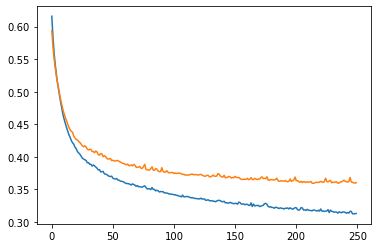

In [39]:
# history 이용
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.25, stratify = Y)
accuracy = []

for train_idx, test_idx in skf.split(X,Y):
    model = Sequential()
    model.add(Dense(16, input_dim = 20, activation = 'relu'))
    model.add(Dense(10, activation = 'relu'))
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = 'accuracy')
    history = model.fit(X.iloc[train_idx],Y.iloc[train_idx], validation_data = [x_train,y_train], epochs = 250, batch_size = 100)
    
    accuracy.append(model.evaluate(X.iloc[test_idx],Y.iloc[test_idx])[1])

model_loss = history.history['loss']
model_vloss = history.history['val_loss']

x_len = np.arange(len(model_loss))

plt.plot(x_len,model_loss)
plt.plot(x_len,model_vloss)

plt.show()

Epoch 1/500
7/7 [==============================] - 1s 37ms/step - loss: 1.0512 - accuracy: 0.3832 - val_loss: 0.9323 - val_accuracy: 0.3857
Epoch 2/500
7/7 [==============================] - 0s 7ms/step - loss: 0.8620 - accuracy: 0.3757 - val_loss: 0.7876 - val_accuracy: 0.3453
Epoch 3/500
7/7 [==============================] - 0s 9ms/step - loss: 0.7580 - accuracy: 0.3323 - val_loss: 0.7210 - val_accuracy: 0.4350
Epoch 4/500
7/7 [==============================] - 0s 10ms/step - loss: 0.7125 - accuracy: 0.4731 - val_loss: 0.6896 - val_accuracy: 0.5650
Epoch 5/500
7/7 [==============================] - 0s 9ms/step - loss: 0.6846 - accuracy: 0.6018 - val_loss: 0.6621 - val_accuracy: 0.6233
Epoch 6/500
7/7 [==============================] - 0s 11ms/step - loss: 0.6526 - accuracy: 0.6482 - val_loss: 0.6341 - val_accuracy: 0.6368
Epoch 7/500
7/7 [==============================] - 0s 10ms/step - loss: 0.6184 - accuracy: 0.6677 - val_loss: 0.6069 - val_accuracy: 0.6682
Epoch 8/500
7/7 [======

7/7 [==============================] - 0s 7ms/step - loss: 0.3800 - accuracy: 0.8308 - val_loss: 0.4460 - val_accuracy: 0.7892
Epoch 60/500
7/7 [==============================] - 0s 9ms/step - loss: 0.3799 - accuracy: 0.8278 - val_loss: 0.4435 - val_accuracy: 0.8027
Epoch 61/500
7/7 [==============================] - 0s 7ms/step - loss: 0.3786 - accuracy: 0.8293 - val_loss: 0.4433 - val_accuracy: 0.7982
Epoch 62/500
7/7 [==============================] - 0s 6ms/step - loss: 0.3789 - accuracy: 0.8368 - val_loss: 0.4429 - val_accuracy: 0.8027
Epoch 63/500
7/7 [==============================] - 0s 7ms/step - loss: 0.3775 - accuracy: 0.8308 - val_loss: 0.4417 - val_accuracy: 0.8072
Epoch 64/500
7/7 [==============================] - 0s 6ms/step - loss: 0.3773 - accuracy: 0.8249 - val_loss: 0.4419 - val_accuracy: 0.8027
Epoch 65/500
7/7 [==============================] - 0s 7ms/step - loss: 0.3760 - accuracy: 0.8368 - val_loss: 0.4421 - val_accuracy: 0.7937
Epoch 66/500
7/7 [===============

7/7 [==============================] - 0s 8ms/step - loss: 0.3497 - accuracy: 0.8548 - val_loss: 0.4397 - val_accuracy: 0.8117
Epoch 118/500
7/7 [==============================] - 0s 9ms/step - loss: 0.3487 - accuracy: 0.8503 - val_loss: 0.4382 - val_accuracy: 0.8251
Epoch 119/500
7/7 [==============================] - 0s 7ms/step - loss: 0.3498 - accuracy: 0.8443 - val_loss: 0.4400 - val_accuracy: 0.8117


<function matplotlib.pyplot.show(close=None, block=None)>

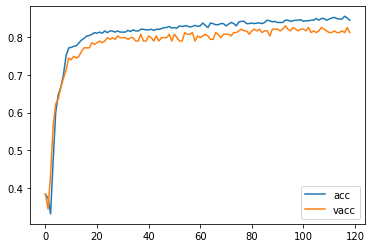

In [44]:
# 모델 최적화
import os
from keras.callbacks import ModelCheckpoint, EarlyStopping

model_dir = './model/'
if not os.path.exists(model_dir):
    os.mkdir(model_dir)

modelpath = "./model/{epoch:}-{val_accuracy:}.hdf5"    
checkpoint = ModelCheckpoint(filepath = modelpath, monitor = 'val_accuracy', save_best_only=True)
early_stop = EarlyStopping(monitor = 'val_accuracy', patience = 25)

model = Sequential()
model.add(Dense(32,input_dim = 20, activation = 'relu'))
model.add(Dense(10, activation = 'relu'))
model.add(Dense(1,activation = 'sigmoid'))
model.compile(loss = 'binary_crossentropy',optimizer = 'adam', metrics = 'accuracy')
history = model.fit(x_train,y_train, validation_data = (x_test,y_test), epochs = 500, batch_size = 100, callbacks = [early_stop, checkpoint])

model_acc = history.history['accuracy']
model_vacc = history.history['val_accuracy']
x_len = np.arange(len(model_acc))

plt.plot(x_len,model_acc, label = 'acc')
plt.plot(x_len,model_vacc, label = 'vacc')
plt.legend()

plt.show
